# T-matrix code for calculating reflectance and transmittance of a multilayered dielectric stack for both TE and TM polarization

***

* Original code written by Naresh Emani in 2016. Adapted from textbook, "Pochi Yeh Optical waves in layered media", Ch. 5 - Matrix Formulation for Isotropic Layered Media

* Adapted by Jinal Tapar to validate examples in textbook by S. Orfanidis


***



***
**Example #1**
Example of Orfanidis EM Waves and Antennas Ch 8. p 337, Fig 8.8.2 Calculate TM and TE reflectances for $n_H = 2.32$, $n_L = 1.38$ with $N = 30$ bilayers
***

In [2]:
######################################################
################ Routine definitions #################
######################################################

from IPython import get_ipython
get_ipython().magic('reset -sf')
get_ipython().magic('clear')

import sys, os, time
import numpy as np, matplotlib.pyplot as plt, seaborn as sb
from numpy import pi; from scipy.interpolate import interp1d; from matplotlib.gridspec import GridSpec
plt.rcParams['figure.figsize']=(8,4)

nm=1e-9;
um=1e-6;
c=3e8;


In [3]:
######################################################
################## User Inputs #######################
######################################################
  
############################ Reflection multilayer p 337, Fig 8.8.2 #######################################
#=============== Calculate TM and TE reflectances for nH = 2.32, nL = 1.38 with N = 30 bilayers============
###########################################################################################################

NUM_LAYERS = 60               # Enter the number of layers excluding substrate and superstrate
n_SUP = 1.0                   # Should be real
n_SUB = 1.52                  # Should be real

lam0 =500*nm                  # Free space wavelength
nH = 2.32                     # High refractive index   
nL = 1.38                     # low refractive index

dH = (0.25/2.32)*lam0         # quarter wavelength thickness of high index layer
dL = (0.25/1.38)*lam0         # quarter wavelength thickness of low index layer


ANG=np.array([0,45,80])*pi/180
WVL = np.linspace(300,800,501)*nm


n_SLAB = np.zeros(NUM_LAYERS)
di = np.zeros(NUM_LAYERS)

for i in range(NUM_LAYERS):
    if i%2==0:
        n_SLAB[i] = nH
        di[i] = dH
    else:
        n_SLAB[i] = nL
        di[i] = dL

if NUM_LAYERS==0:
    P1 = np.eye(2)
    P2 = np.eye(2)

RRR= np.zeros(shape=(2,len(ANG),len(WVL)) , dtype = float)                  # TM/TE pol, lambda, inc_angle
TTT = np.zeros(shape=(2,len(ANG),len(WVL)) , dtype = float)
AAA = np.zeros(shape=(2,len(ANG),len(WVL)) , dtype = float)
ttt = np.zeros(shape=(2,len(ANG),len(WVL)) , dtype = complex)
rrr = np.zeros(shape=(2,len(ANG),len(WVL)) , dtype = complex)
Dp_sub = np.zeros(shape=(2,2) , dtype = complex) 
Dp_sup = np.zeros(shape=(2,2) , dtype = complex)
Ds_sub = np.zeros(shape=(2,2) , dtype = complex)
Ds_sup = np.zeros(shape=(2,2) , dtype = complex)

omega=c/WVL

for idx1 in range(len(ANG)):
    for idx2 in range(len(WVL)):
        theta0 = ANG[idx1]
        lam = WVL[idx2]
#         Calculate dynamic matrices of substrate and superstrate
        theta_sub = np.arcsin(np.sin(theta0)*n_SUP/n_SUB)

#       TM or p polarization
        Dp_sup = np.array([[np.cos(theta0), np.cos(theta0)], [n_SUP, -n_SUP]])
        Dp_sub = np.array([[np.cos(theta_sub), np.cos(theta_sub)], [n_SUB, -n_SUB]])

#       TE Polarization
        Ds_sup = np.array([[1, 1], [n_SUP*np.cos(theta0), -n_SUP*np.cos(theta0)]])
        Ds_sub = np.array([[1, 1], [n_SUB*np.cos(theta_sub), -n_SUB*np.cos(theta_sub)]])
                            
#        % Calculate the dynamical and propagation matrices for intermediate layers
        P1i = np.eye(2 , dtype = complex) 
        P2i = np.eye(2 , dtype = complex) 

        for idx3 in range(NUM_LAYERS):
                      
            n = n_SLAB[idx3]                
            d = di[idx3]
            
            theta=np.arcsin(np.sin(theta0)*n_SUP/n);    
            kx = n*2*pi*np.cos(theta)/lam;
#            Propagation matrix
#            P=[exp(j*kx*d),0;0,exp(-j*kx*d)];
            Prop = np.array([[np.exp(1j*kx*d), 0], [0,np.exp(-1j*kx*d)]])
#            Dynamical matrix for TM polarization
            Dp = np.array([[np.cos(theta), np.cos(theta)], [n, -n]])
            
#            Dynamical matrix for TE Polarization
            Ds = np.array([[1, 1], [n*np.cos(theta), -n*np.cos(theta)]])

            
            Dp_inv = np.linalg.solve(Dp, np.eye(2)) 
            Ds_inv = np.linalg.solve(Ds, np.eye(2)) 
            
            P1i = P1i.dot(Dp).dot(Prop).dot(Dp_inv)
            P2i = P2i.dot(Ds).dot(Prop).dot(Ds_inv)
            
        P1 = P1i
        P2 = P2i
#       Perform calculation by matrix inversion. INV(A) can be
#       unstable and give RCOND warning. Backslash or MLDIVIDE
#       performs calculation in a better way and provides more
#       numerical stability
        
#        Mp=np.linalg.lstsq(Dp_sup,np.dot(P1,Dp_sub))[0]     # Return only solution...ignoring residuals
#        Ms=np.linalg.lstsq(Ds_sup,np.dot(P2,Ds_sub))[0]
        
        Mp=np.linalg.solve(Dp_sup,np.dot(P1,Dp_sub))     # Return only solution...ignoring residuals
        Ms=np.linalg.solve(Ds_sup,np.dot(P2,Ds_sub))
#
##        %Calculate R & T for p polarization
        rrr[0,idx1,idx2]= Mp[1,0]/Mp[0,0]
        ttt[0,idx1,idx2]= 1/Mp[0,0]
        RRR[0,idx1,idx2]=abs(rrr[0,idx1,idx2])**2;
        TTT[0,idx1,idx2]=(n_SUB*np.cos(theta_sub))/(n_SUP*np.cos(theta0))*abs(ttt[0,idx1,idx2])**2
        
##        %Calculate R & T for s polarization
        rrr[1,idx1,idx2]= Ms[1,0]/Ms[0,0]
        ttt[1,idx1,idx2]= 1/Ms[0,0]
        RRR[1,idx1,idx2]=abs(rrr[1,idx1,idx2])**2;
        TTT[1,idx1,idx2]=(n_SUB*np.cos(theta_sub))/(n_SUP*np.cos(theta0))*abs(ttt[1,idx1,idx2])**2
                


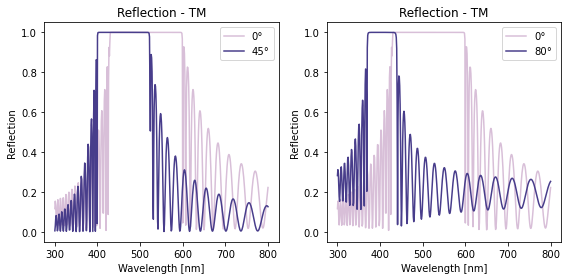

In [4]:
######################################################
################## TM Polarization ###################
######################################################

plt.subplot(121)
plt.title("Reflection - TM")
plt.plot(WVL/nm, RRR[0,0,:], label='0\u00b0', color='thistle', linestyle='-')
plt.plot(WVL/nm, RRR[0,1,:], label='45\u00b0', color='darkslateblue', linestyle='-')
plt.ylabel('Reflection')
plt.xlabel('Wavelength [nm]')
plt.ylim([-0.05, 1.05])
plt.legend()

plt.subplot(122)
plt.title("Reflection - TM")
plt.plot(WVL/nm, RRR[0,0,:], label='0\u00b0', color='thistle', linestyle='-')
plt.plot(WVL/nm, RRR[0,2,:], label='80\u00b0', color='darkslateblue', linestyle='-')
plt.ylabel('Reflection')
plt.xlabel('Wavelength [nm]')
plt.ylim([-0.05, 1.05])
plt.legend()
    
plt.tight_layout()


The reflection bandwidth intervals for TM incidence at $0^\circ$, $45^\circ$ and $80^\circ$ angles are indicated.

**Key points to remember**
* The bands are shrinking with increasing angle of incidence.
* The bands are shifting towards lower wavelengths.
* The common band between normal incidence and oblique incidence is reducing with increasing angle of incidence.
       


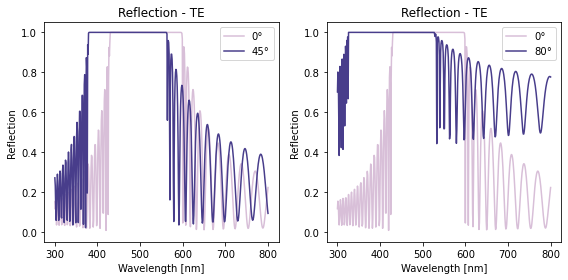

In [5]:
######################################################
################## TE Polarization ###################
######################################################

plt.subplot(121)
plt.title("Reflection - TE")
plt.plot(WVL/nm, RRR[1,0,:], label='0\u00b0', color='thistle', linestyle='-')
plt.plot(WVL/nm, RRR[1,1,:], label='45\u00b0', color='darkslateblue', linestyle='-')
plt.ylabel('Reflection')
plt.xlabel('Wavelength [nm]')
plt.ylim([-0.05, 1.05])
plt.legend()

plt.subplot(122)
plt.title("Reflection - TE")
plt.plot(WVL/nm, RRR[1,0,:], label='0\u00b0', color='thistle', linestyle='-')
plt.plot(WVL/nm, RRR[1,2,:], label='80\u00b0', color='darkslateblue', linestyle='-')
plt.ylabel('Reflection')
plt.xlabel('Wavelength [nm]')
plt.ylim([-0.05, 1.05])
plt.legend()

plt.tight_layout()

The reflection bandwidth intervals for TE incidence at $0^\circ$, $45^\circ$ and $80^\circ$ angles are indicated.

**Key points to remember**
* The bands are expanding with increasing angle of incidence.
* The bands are shifting towards lower wavelengths.
* The common band between normal incidence and oblique incidence is reducing with increasing angle of incidence.



***
**Example #2**

Example of Orfanidis EM Waves and Antennas Ch 8. p 344, Fig 8.9.2 Polarization beam splitter, $n_a = n_b = 1.5532$, $n_H = 2.3$, $n_L = 1.25$ with $N = 5$ bilayers

***

In [6]:
############################ Polarizing beam splitter p 344, Fig 8.9.2 #######################################
#==== Calculate TM and TE reflectances for na = nb = 1.5532, nH = 2.3, nL = 1.25 with N = 5 bilayers============
###########################################################################################################
NUM_LAYERS = 11   #Enter the number of layers excluding substrate and superstrate
n_SUP = 1.5532    # Should be real
n_SUB = 1.5532    # Should be real

lam0 = 718.38*nm   # Free space wavelength
nH = 2.3           # High refractive index
nL = 1.25          # Low refreactive index

dH = (0.25/nH)*lam0  # quarter wavelenth thickness of high index layer
dL = (0.25/nL)*lam0  # quarter wavelength thickness of low index layer 
    
ANG=np.array([45])*pi/180
WVL = np.linspace(300,800,501)*nm
        
n_SLAB = np.zeros(NUM_LAYERS)
di = np.zeros(NUM_LAYERS)
for i in range(NUM_LAYERS):
    if i%2==0:
        n_SLAB[i] = nH
        di[i] = dH
    else:
        n_SLAB[i] = nL
        di[i] = dL        

if NUM_LAYERS==0:
    P1 = np.eye(2)
    P2 = np.eye(2)

RRR= np.zeros(shape=(2,len(ANG),len(WVL)) , dtype = float)                  # TM/TE pol, lambda, inc_angle
TTT = np.zeros(shape=(2,len(ANG),len(WVL)) , dtype = float)
AAA = np.zeros(shape=(2,len(ANG),len(WVL)) , dtype = float)
ttt = np.zeros(shape=(2,len(ANG),len(WVL)) , dtype = complex)
rrr = np.zeros(shape=(2,len(ANG),len(WVL)) , dtype = complex)
Dp_sub = np.zeros(shape=(2,2) , dtype = complex) 
Dp_sup = np.zeros(shape=(2,2) , dtype = complex)
Ds_sub = np.zeros(shape=(2,2) , dtype = complex)
Ds_sup = np.zeros(shape=(2,2) , dtype = complex)

omega=c/WVL

for idx1 in range(len(ANG)):
    for idx2 in range(len(WVL)):
        theta0 = ANG[idx1]
        lam = WVL[idx2]
#         Calculate dynamic matrices of substrate and superstrate
        theta_sub = np.arcsin(np.sin(theta0)*n_SUP/n_SUB)

#       TM or p polarization
        Dp_sup = np.array([[np.cos(theta0), np.cos(theta0)], [n_SUP, -n_SUP]])
        Dp_sub = np.array([[np.cos(theta_sub), np.cos(theta_sub)], [n_SUB, -n_SUB]])

#       TE Polarization
        Ds_sup = np.array([[1, 1], [n_SUP*np.cos(theta0), -n_SUP*np.cos(theta0)]])
        Ds_sub = np.array([[1, 1], [n_SUB*np.cos(theta_sub), -n_SUB*np.cos(theta_sub)]])
                            
#        % Calculate the dynamical and propagation matrices for intermediate layers
        P1i = np.eye(2 , dtype = complex) 
        P2i = np.eye(2 , dtype = complex) 

        for idx3 in range(NUM_LAYERS):
                      
            n = n_SLAB[idx3]                
            d = di[idx3]
            
            theta=np.arcsin(np.sin(theta0)*n_SUP/n);    
            kx = n*2*pi*np.cos(theta)/lam;
#            Propagation matrix
#            P=[exp(j*kx*d),0;0,exp(-j*kx*d)];
            Prop = np.array([[np.exp(1j*kx*d), 0], [0,np.exp(-1j*kx*d)]])
#            Dynamical matrix for TM polarization
            Dp = np.array([[np.cos(theta), np.cos(theta)], [n, -n]])
            
#            Dynamical matrix for TE Polarization
            Ds = np.array([[1, 1], [n*np.cos(theta), -n*np.cos(theta)]])

            
            Dp_inv = np.linalg.solve(Dp, np.eye(2)) 
            Ds_inv = np.linalg.solve(Ds, np.eye(2)) 
            
            P1i = P1i.dot(Dp).dot(Prop).dot(Dp_inv)
            P2i = P2i.dot(Ds).dot(Prop).dot(Ds_inv)
            
        P1 = P1i
        P2 = P2i
#       Perform calculation by matrix inversion. INV(A) can be
#       unstable and give RCOND warning. Backslash or MLDIVIDE
#       performs calculation in a better way and provides more
#       numerical stability
        
#        Mp=np.linalg.lstsq(Dp_sup,np.dot(P1,Dp_sub))[0]     # Return only solution...ignoring residuals
#        Ms=np.linalg.lstsq(Ds_sup,np.dot(P2,Ds_sub))[0]
        
        Mp=np.linalg.solve(Dp_sup,np.dot(P1,Dp_sub))     # Return only solution...ignoring residuals
        Ms=np.linalg.solve(Ds_sup,np.dot(P2,Ds_sub))
#
##        %Calculate R & T for p polarization
        rrr[0,idx1,idx2]= Mp[1,0]/Mp[0,0]
        ttt[0,idx1,idx2]= 1/Mp[0,0]
        RRR[0,idx1,idx2]=abs(rrr[0,idx1,idx2])**2;
        TTT[0,idx1,idx2]=(n_SUB*np.cos(theta_sub))/(n_SUP*np.cos(theta0))*abs(ttt[0,idx1,idx2])**2
        
##        %Calculate R & T for s polarization
        rrr[1,idx1,idx2]= Ms[1,0]/Ms[0,0]
        ttt[1,idx1,idx2]= 1/Ms[0,0]
        RRR[1,idx1,idx2]=abs(rrr[1,idx1,idx2])**2;
        TTT[1,idx1,idx2]=(n_SUB*np.cos(theta_sub))/(n_SUP*np.cos(theta0))*abs(ttt[1,idx1,idx2])**2
                


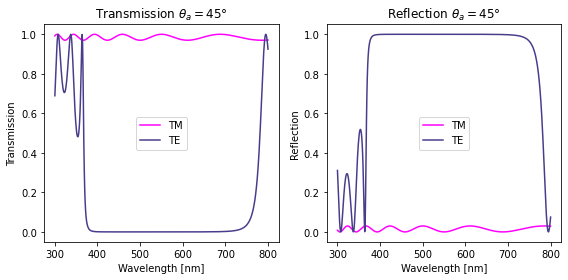

In [7]:
plt.subplot(121)
plt.title("Transmission $ \u03B8_a = 45\u00b0$")
plt.plot(WVL/nm, TTT[0,0,:], label='TM', color='magenta', linestyle='-')
plt.plot(WVL/nm, TTT[1,0,:], label='TE', color='darkslateblue', linestyle='-')
plt.ylabel('Transmission')
plt.xlabel('Wavelength [nm]')
plt.ylim([-0.05, 1.05])
plt.legend()
    
plt.subplot(122)
plt.title("Reflection $ \u03B8_a = 45\u00b0$")
plt.plot(WVL/nm, RRR[0,0,:], label='TM', color='magenta', linestyle='-')
plt.plot(WVL/nm, RRR[1,0,:], label='TE', color='darkslateblue', linestyle='-')
plt.ylabel('Reflection')
plt.xlabel('Wavelength [nm]')
plt.ylim([-0.05, 1.05])
plt.legend()
plt.tight_layout()
